Quantum Simulation of a dissipative system by utilizing intrinsic noise on NISQ device

The theory of open quantum system supports most modern research in quantum mechanics and its applications in many areas. In this project, we would like to design an algorithm which utilize the noise on IBMQ system to simulate an open quantum system. We hope that our result could pave the way to a new perspective of quantum simulation.

(Techinical details and background information along with diagrams are presented in the supplementary information)

In [1]:
# Import necessary modules for math, quantum circuit, and data visualization
import qiskit
from qiskit import Aer, execute, QuantumCircuit, IBMQ, execute
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

The model we used to simulate is the exciton model for excitation energy transfer, which is important 
in condensed phase chemical dynamics. 

To encode the system into the quantum computer, we employ a Jordan-Wigner type encoding, which use qubit state to represent exciton state(occupancy), and transform the second-quantized Hamiltonian to propagate system accordingly. 

For the dissipative part, we append the XX-pulse (which should be an identity operation on a “perfect” quantum computer) at the end of the simulation circuit proportional to each simulation time step to introduce the desired decoherence effect due to the gate imperfection, and the proportionality constant can be tuned to achieved different magnitudes of the system-bath coupling.

In [2]:
#This function generate the disspative evolution circuit for the symmetric dimer system using the Jorden-Wigner 
#type encoding. i.e. qubit state = exciton occupation state.

def generate_evolution_circuit(time, damp):
    qc = QuantumCircuit(2,2)
    
    # Excite the first qubit to create |01> state, this prepares the exciton state with right one
    # excited.
    qc.x(0)
    
    # First-order trotterized evolution circuit for the target Hamiltonian (please refer to the
    # background information)
    # Ref: "Scalable Quantum Simulation of Molecular Energies" Phys. Rev. X 6, 031007
    qc.ry(pi/2, 0)
    qc.ry(pi/2, 1)
    
    qc.cx(0,1)
    qc.rz(2*time,1)
    qc.cx(0,1)
    
    qc.ry(-pi/2, 0)
    qc.ry(-pi/2, 1)
    
    qc.rx(-pi/2, 0)
    qc.rx(-pi/2, 1)
    
    qc.cx(0,1)
    qc.rz(2*time,1)
    qc.cx(0,1)
    
    qc.rx(pi/2, 0)
    qc.rx(pi/2, 1)
    
    # XX pulses are appended at the end of the propagator circuit, with the number propotional to
    # the simulation time. This accounts for the large damping effect in the long time dynamics.
    # Note: XX pulses should be a identity operation for a pefect quantum computer. 
    for i in range(int(damp*time)):
        qc.x(0)
        qc.x(0)
        qc.x(1)
        qc.x(1)
    qc.measure([0,1],[0,1])
    
    return qc


In [3]:
#This returns the renormalized population within one-excitation manifold.

def get_site_population_norm(counts, site):
    total = counts.get('01', 0) + counts.get('10', 0)
    
    population = 0
    
    if site == 1 :
        population = counts.get('01', 0) / total
    if site == 2 :
        population = counts.get('10', 0) / total
   
    return population

In [4]:
# load the account
IBMQ.load_account()
provider = IBMQ.get_provider(group = "ntu-internal")
backend = provider.get_backend('ibmq_bogota')

damp = 20
circ_list = []
times = np.arange(0,8,0.2)
for t in times:
    circ_list.append(generate_evolution_circuit(t, damp))
job = execute(circ_list, backend = backend, optimization_level = 0, shots = 8000)
print(job.job_id())

5f58251967453d00192294da


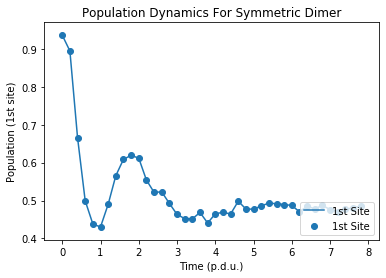

In [5]:
result = job.result()
populations_1_site = []

for i in range(len(times)):
    counts = result.get_counts(i)
    populations_1_site.append(get_site_population_norm(counts,1))

plt.title("Population Dynamics For Symmetric Dimer")
plt.plot(times,populations_1_site,label = "1st Site")
plt.scatter(times,populations_1_site,label = "1st Site")
plt.xlabel("Time (p.d.u.)")
plt.ylabel("Population (1st site)")
plt.legend(loc='lower right')
plt.savefig("Population Dynamics",dpi = 400)